In [42]:
! pip install torchvision

Defaulting to user installation because normal site-packages is not writeable


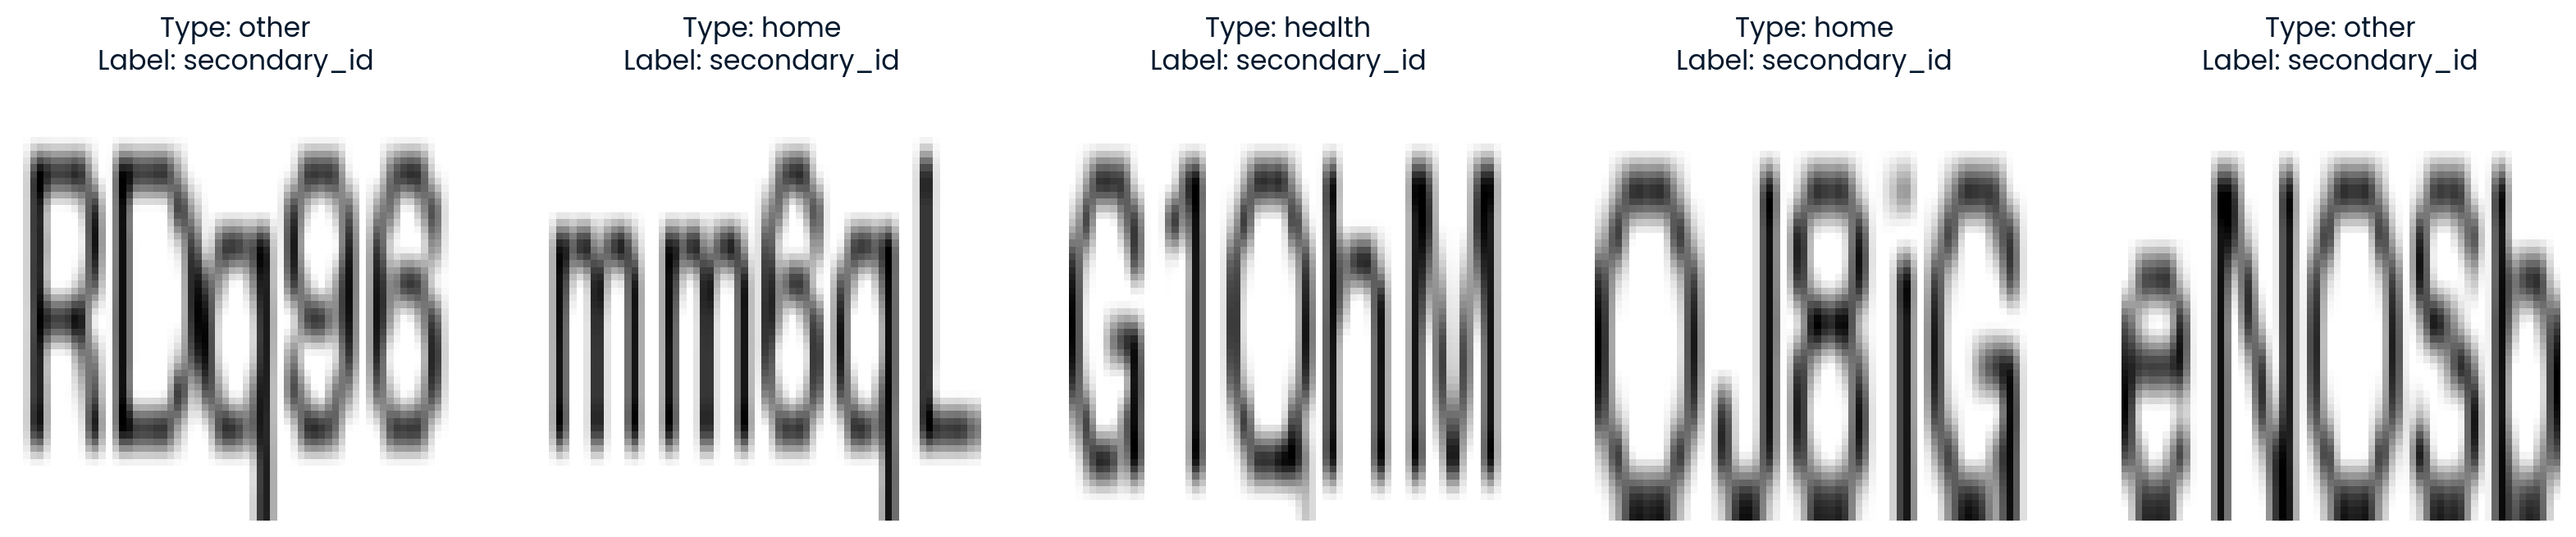

In [43]:
# Import the necessary libraries
import matplotlib.pyplot as plt
import numpy as np
from project_utils import ProjectDataset
import pickle 
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

# Load the data
dataset = pickle.load(open('ocr_insurance_dataset.pkl', 'rb'))

# Define a function to visualize codes with their corresponding types and labels 
def show_dataset_images(dataset, num_images=5):
    fig, axes = plt.subplots(1, min(num_images, len(dataset)), figsize=(20, 4))
    for ax, idx in zip(axes, np.random.choice(len(dataset), min(num_images, len(dataset)), False)):
        img, lbl = dataset[idx]
        ax.imshow((img[0].numpy() * 255).astype(np.uint8).reshape(64,64), cmap='gray'), ax.axis('off')
        ax.set_title(f"Type: {list(dataset.type_mapping.keys())[img[1].tolist().index(1)]}\nLabel: {list(dataset.label_mapping.keys())[list(dataset.label_mapping.values()).index(lbl)]}")
    plt.show()

# Inspect 5 codes images from the dataset
show_dataset_images(dataset)

In [44]:
img, lbl = dataset[0]
print("first comp:\n", img[0].shape)
print("second comp:\n",img[1])
print(lbl)

first comp:
 torch.Size([1, 64, 64])
second comp:
 tensor([1., 0., 0., 0., 0.])
0


In [45]:
# Start coding here: create the class of the model 
class OCRModel(nn.Module):
    def __init__(self, num_classes):
        super(OCRModel, self).__init__()
        # Define sub-networks as sequential models
        self.image_layer = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.MaxPool2d(kernel_size=2),
            nn.ELU(),
            nn.Flatten(),
            nn.Linear(16*32*32, 128)
        )
        self.type_layer = nn.Sequential(
            nn.Linear(5, 8),
            nn.ELU(), 
        )
        self.classifier = nn.Sequential(
            nn.Linear(128 + 8, num_classes), 
        )
    def forward(self, x_image, x_type):
	   	# Pass the x_image and x_type through appropriate layers
        x_image = self.image_layer(x_image)
        x_type = self.type_layer(x_type)
        # Concatenate x_image and x_type
        x = torch.cat((x_image, x_type), dim=1)
        return self.classifier(x)

In [46]:
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
#dataset definition
class DigiDataset(Dataset):
    def __init__(self, transform, samples):
		# Assign transform and samples to class attributes
        self.transform = transform
        self.samples = samples
                    
    def __len__(self):
		# Return number of samples
        return len(self.samples)

    def __getitem__(self, idx):
      	# Unpack the sample at index idx
        img, label = self.samples[idx]
        #img = Image.open(img_path).convert('L')
        # Transform the image
        img_extr = (img[0].numpy() * 255).astype(np.uint8)
        img_transformed = self.transform(img_extr)
        return img[0], img[1], label
    
dataset_train = DigiDataset(
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((64, 64)),
    ]),
    samples=dataset,
)

dataloader_train = DataLoader(
    dataset_train, shuffle=True, batch_size=3,
)

In [47]:
#training loop
# Define the model
model = OCRModel(num_classes=2)
# Define the loss function
criterion = nn.CrossEntropyLoss()
# Define the optimizer
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

for epoch in range(10):
    running_loss = 0.0
    for img, typ, labels in dataloader_train: 
        optimizer.zero_grad()
        outputs = model(img, typ)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    epoch_loss = running_loss / len(dataloader_train)
    print(f"Epoch {epoch+1}, Loss: {epoch_loss:.4f}")


Epoch 1, Loss: 5.6751
Epoch 2, Loss: 0.9372
Epoch 3, Loss: 0.8689
Epoch 4, Loss: 0.4286
Epoch 5, Loss: 0.3899
Epoch 6, Loss: 0.2959
Epoch 7, Loss: 0.3247
Epoch 8, Loss: 0.2302
Epoch 9, Loss: 0.1393
Epoch 10, Loss: 0.0965
